In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
!pip install fastai
!pip install duckduckgo-search
!pip install ipywidgets



Importing the install libraries and defining a function that allows us to grab urls from images online, so they can later be downloaded

In [36]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.widgets import *

def search_images(term, max_images=120):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [5]:
urls = search_images('happy human face', max_images=1)
urls[0]

Searching for 'happy human face'


'https://i.pinimg.com/736x/37/8f/fa/378ffa7b4bc07f190ee35f85ed816377--happy-smile-happy-faces.jpg'

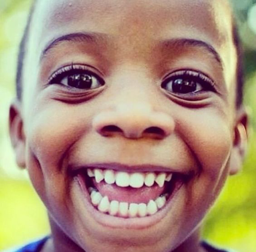

In [6]:
from fastdownload import download_url
dest = 'happy.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'sad human face'


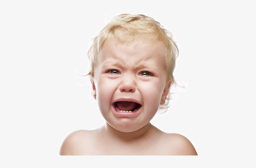

In [7]:
download_url(search_images('sad human face', max_images=1)[0], 'sad.jpg', show_progress=False)
Image.open('sad.jpg').to_thumb(256,256)

In [37]:
searches = 'sad','happy'
path = Path('happy_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} human face'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'sad human face'
Searching for 'happy human face'


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [38]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

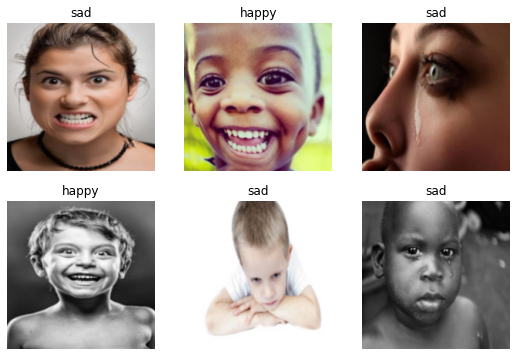

In [41]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')],
    batch_tfms=aug_transforms()
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [42]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

In [44]:
is_happy,_,probs = learn.predict(PILImage.create('happy.jpg'))
print(f"This is a: {is_happy}.")
print(f"Probability person is happy: {probs[0]:.4f}")

This is a: happy.
Probability person is happy: 0.9999


This cleaner allows us to take a look at our training and validation sets, allowing us remove any data that is labbeled incorrectly or does not fit in with our data set.

In [46]:
cleaner = ImageClassifierCleaner(learn)
cleaner

ImageClassifierCleaner doesn't do anything on its own, so we must delete them using the indices that the function gives us.

In [47]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

While not as useful in this case, as we only have 2 categories, the confusion allows us to see where to model is making mistakes.

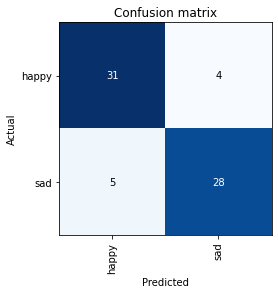

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [50]:
learn.export('model.pkl')